In [2]:
import os, gc, pickle, random, time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt


from tqdm import tqdm
from skimage import data, io, util, transform
from skimage.color import rgb2gray
from skimage.feature import match_descriptors, plot_matches, SIFT

from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
import torch.optim as optim

import torch
import torch.nn as nn
from torchvision import models
from torchvision.io import read_image
import torchvision.transforms as T
from torch.nn.functional import relu
import torch.nn.functional as F

from collections import defaultdict


classes = [ 'danger', 'interdiction', 'obligation', 'stop', 'ceder', 'frouge', 'forange', 'fvert' ]

In [3]:
file_list = []

def process_csv(csv):
    csv_processed = []
    for line in csv.split('\n'):
        sp = line.split(',')
        if not len(sp) == 5 or sp[4] == 'ff':
            continue
        csv_processed.append([sp[0],sp[1], sp[2],sp[3],classes.index(sp[4]) ])
    np_array = np.array(csv_processed).astype(np.int16)
    if len(csv_processed) == 0:
        np_array = np.zeros((0, 5))

    return np_array


preprocess = T.Compose([
    T.ConvertImageDtype(torch.float32),
    #T.Resize(256),
    #T.CenterCrop(224),
    T.Normalize( mean=[0.3282, 0.3425, 0.3531], std=[0.2466, 0.2574, 0.2731] )
])

for subdir, dirs, files in os.walk('/kaggle/input/sy32-panneaux-2/train/images'):
    for file in tqdm(files):
        filepath = subdir + os.sep + file
        filepath_csv = '/kaggle/input/sy32-panneaux-2/train/labels/' + file.replace(".jpg",".csv")
        
        #fgf = util.img_as_float32(io.imread(filepath))
        fgf = preprocess(read_image(filepath))

        csv_data = None
        with open(filepath_csv, 'r') as csv:
            csv_data = csv.read()

        file_list.append([file.replace('.jpg', ''), fgf, process_csv(csv_data)])

100%|██████████| 703/703 [00:19<00:00, 35.62it/s]


## Augmentation
- Flip horizontal
- small rotations (-45 - 45 degrees)
- 

In [ ]:
'''

parts = 5
entries_per_part = round(len(file_list/parts))
file_list = pickle.load(open('/kaggle/working/file_list.pickle','rb'))


'''

In [5]:
class SmallUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(32, 32, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(32, 32, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(32, n_class, kernel_size=1)
    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

## Smaller UNET ~2M

In [4]:
class SmallUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(3, 16, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(16, 16, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(32, 32, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(32, 32, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(16, 16, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(16, n_class, kernel_size=1)
    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out
    


In [5]:
def generate_mask(image, image_as_background=False):
    mask = np.zeros(list(image[1].shape)[-2:])

    if image_as_background:
        mask[:, :] = rgb2gray(np.moveaxis(image[1].numpy(),0,2))
        
    if image[2].shape[0] == 0:
        return mask
    
    for (xmin, ymin, xmax, ymax, c) in image[2]:
        mask[ymin : ymax, xmin : xmax] = 1.0
    return mask

MAX_DIM = 512

def divide_image(image, three_channel=False, step_size=128, output_size=256):
    if three_channel:
        X, Y, Z = image.shape
    else:
        X, Y = image.shape[:2]

    # Calculate number of blocks needed
    nx = (X + step_size - 1) // step_size  # Number of steps along X
    ny = (Y + step_size - 1) // step_size  # Number of steps along Y

    ims = []
    for y in range(ny):
        for x in range(nx):
            # Compute start and end indices for x and y
            
            x2 = min(x *step_size + output_size, X)
            y2 = min(y * step_size + output_size, Y)

            x1 = x2 - output_size
            y1 = y2 - output_size 

        
            im = image[x1:x2, y1:y2]
                
            ims.append(im)

    return ims

In [6]:
def divide_image(image,three_channel=False):
    images_small = []

    arrays = np.array_split(image, np.ceil( image.shape[0] / MAX_DIM ))
    for array in arrays:
        images_small.extend(np.array_split(array, np.ceil( array.shape[1] / MAX_DIM ),axis=1))

    images = [] 

    for idx, img in enumerate(images_small):
        if three_channel:
            W,H,C=img.shape
            image = np.zeros((MAX_DIM, MAX_DIM, C),dtype=np.float32)
        else:
            W,H = img.shape
            image = np.zeros((MAX_DIM, MAX_DIM),dtype=np.float32)
        image[:W,:H] = img[:, :]
        images.append(image)
        
    return images

In [7]:
fig, axs = plt.subplots(1, 5, figsize=(12, 6))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(generate_mask(file_list[idx], True))
    ax.axis('off')

###

fig, axs = plt.subplots(2, 4, figsize=(12, 6))

div = divide_image(file_list[1][1], True)
div1 = divide_image(generate_mask(file_list[1]))


for idx, ax in enumerate(axs.ravel()):
    if idx // 4 == 0:
        ax.imshow(div[idx])
    else:
        ax.imshow(div1[idx % 4])
    ax.axis('off')

TypeError: Invalid shape (512, 512, 750) for image data

Error in callback <function flush_figures at 0x7814306b25f0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

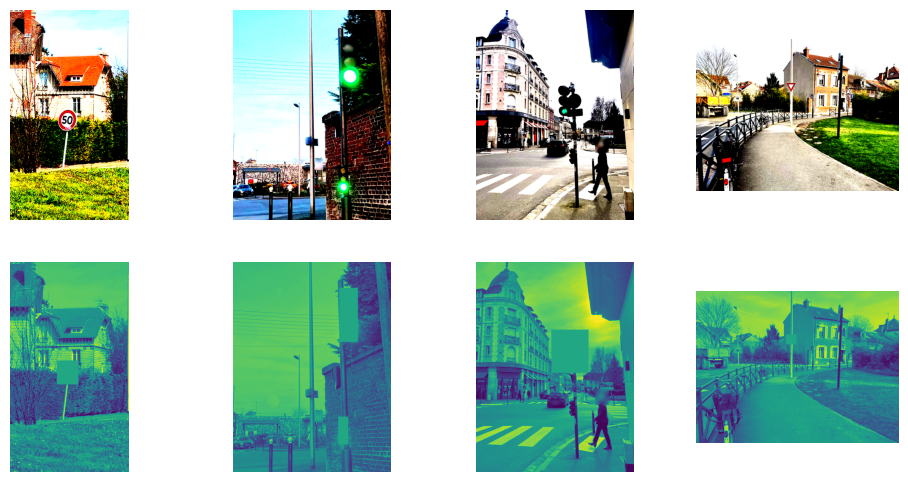

In [7]:

fig, axs = plt.subplots(2, 4, figsize=(12, 6))

for idx, ax in enumerate(axs.ravel()):
    if idx // 4 == 1:
        #ax.imshow(np.moveaxis(file_list[idx][1].numpy(), 0 ,2))
        ax.imshow(generate_mask(file_list[idx % 4], True))
    else:
        ax.imshow(np.moveaxis(file_list[idx][1].numpy(), 0 ,2))
    ax.axis('off')

In [8]:
class CustomImageDataset(Dataset):
    def __init__(self, file_list):
        self.input_file_list = file_list
        self.images = []
        self.masks = []
        
        for file in tqdm(self.input_file_list):
            generated_mask = generate_mask(file, False) 
            
            masks = divide_image(generated_mask)
            images = divide_image(torch.moveaxis(file[1], 0, 2), three_channel=True)
            
            self.images.extend(images)
            self.masks.extend(masks)
            
        self.np_images = np.zeros((len(self.images), 3, 512, 512),dtype=np.float32)
        self.np_masks = np.zeros((len(self.images), 512, 512),dtype=np.float32)
        
        for idx, (image, mask) in tqdm(enumerate(zip(self.images, self.masks))):
            self.np_images[idx] = np.moveaxis(image, -1, 0)
            self.np_masks[idx] = mask


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.np_images[idx], self.np_masks[idx]
        #return np.moveaxis(self.images[idx], -1, 0), self.masks[idx]
        
        
dataset = CustomImageDataset(file_list) #500
#dataset = CustomImageDataset(file_list)

100%|██████████| 703/703 [00:09<00:00, 77.70it/s]
2717it [00:09, 285.07it/s]


In [9]:
def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

    return loss.mean()

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_class = 1 # (10) 9 if you don't count background

model = SmallUNet(num_class).to(device)

if True:
    model.load_state_dict(torch.load('/kaggle/working/model-small-norm-latest.model'))
    model.eval()

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_dataloader = DataLoader(dataset, batch_size=16, shuffle=True, pin_memory=True)

## 322 MB (after clean run)

In [11]:

# torch.Size([4, 512, 70, 70]) torch.Size([4, 512, 71, 71])
for epoch in range(30):
    print("Epoch {}".format(epoch))
    
    metrics = defaultdict(float)
    for inputs, labels in tqdm(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            loss = calc_loss(outputs, labels.reshape(-1, 1, 512, 512), metrics)
            loss.backward()
            optimizer.step()
            
    if epoch % 5 == 0:
        torch.save(model.state_dict(), '/kaggle/working/model-training-norm-{}.model'.format(epoch))
        
    print(metrics['loss'])


Epoch 0


100%|██████████| 170/170 [00:42<00:00,  3.97it/s]


828.3598696291447
Epoch 1


100%|██████████| 170/170 [00:41<00:00,  4.08it/s]


814.01601177454
Epoch 2


100%|██████████| 170/170 [00:41<00:00,  4.07it/s]


813.7533568739891
Epoch 3


100%|██████████| 170/170 [00:41<00:00,  4.07it/s]


804.6022189855576
Epoch 4


100%|██████████| 170/170 [00:41<00:00,  4.07it/s]


788.4981037974358
Epoch 5


100%|██████████| 170/170 [00:41<00:00,  4.07it/s]


822.4424501508474
Epoch 6


100%|██████████| 170/170 [00:41<00:00,  4.08it/s]


797.1896550655365
Epoch 7


100%|██████████| 170/170 [00:41<00:00,  4.08it/s]


771.6856126189232
Epoch 8


100%|██████████| 170/170 [00:41<00:00,  4.07it/s]


774.3749468922615
Epoch 9


100%|██████████| 170/170 [00:41<00:00,  4.08it/s]


783.0201725363731
Epoch 10


100%|██████████| 170/170 [00:41<00:00,  4.07it/s]


781.5193772912025
Epoch 11


100%|██████████| 170/170 [00:41<00:00,  4.08it/s]


773.8258087933064
Epoch 12


100%|██████████| 170/170 [00:41<00:00,  4.07it/s]


742.7132322788239
Epoch 13


100%|██████████| 170/170 [00:41<00:00,  4.08it/s]


746.0237457156181
Epoch 14


100%|██████████| 170/170 [00:41<00:00,  4.08it/s]


744.2783912718296
Epoch 15


100%|██████████| 170/170 [00:41<00:00,  4.07it/s]


742.9042420983315
Epoch 16


100%|██████████| 170/170 [00:41<00:00,  4.08it/s]


764.408164024353
Epoch 17


100%|██████████| 170/170 [00:41<00:00,  4.08it/s]


759.7045140862465
Epoch 18


100%|██████████| 170/170 [00:41<00:00,  4.08it/s]


768.4267377257347
Epoch 19


100%|██████████| 170/170 [00:41<00:00,  4.08it/s]


726.1008976399899
Epoch 20


100%|██████████| 170/170 [00:41<00:00,  4.08it/s]


743.3608667999506
Epoch 21


100%|██████████| 170/170 [00:41<00:00,  4.08it/s]


731.6136532723904
Epoch 22


100%|██████████| 170/170 [00:41<00:00,  4.07it/s]


749.7737857103348
Epoch 23


100%|██████████| 170/170 [00:41<00:00,  4.08it/s]


728.9957430064678
Epoch 24


100%|██████████| 170/170 [00:41<00:00,  4.07it/s]


717.229430615902
Epoch 25


100%|██████████| 170/170 [00:41<00:00,  4.08it/s]


718.4427720010281
Epoch 26


100%|██████████| 170/170 [00:41<00:00,  4.09it/s]


705.3601270020008
Epoch 27


100%|██████████| 170/170 [00:41<00:00,  4.08it/s]


679.4990236163139
Epoch 28


100%|██████████| 170/170 [00:41<00:00,  4.08it/s]


731.1281634867191
Epoch 29


100%|██████████| 170/170 [00:41<00:00,  4.08it/s]

731.5050111114979


## Epoches: 5+5+5+30+30=75


In [27]:

d = torch.from_numpy(dataset.np_images).to(device)

with torch.set_grad_enabled(False):
    pred = model(d)
    
pred.shape

OutOfMemoryError: CUDA out of memory. Tried to allocate 5.71 GiB. GPU 0 has a total capacty of 15.89 GiB of which 1.26 GiB is free. Process 7119 has 14.63 GiB memory in use. Of the allocated memory 12.44 GiB is allocated by PyTorch, and 1.90 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [32]:
torch.save(model.state_dict(), '/kaggle/working/model-small-norm-latest.model')

In [16]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 7760097


In [15]:
test_loader = DataLoader(dataset, batch_size=8, shuffle=True)
inputs_cpu, labels_cpu = next(iter(test_loader))


In [18]:
print(inputs.shape)

torch.Size([16, 3, 512, 512])


torch.Size([8, 3, 512, 512]) torch.Size([8, 512, 512])


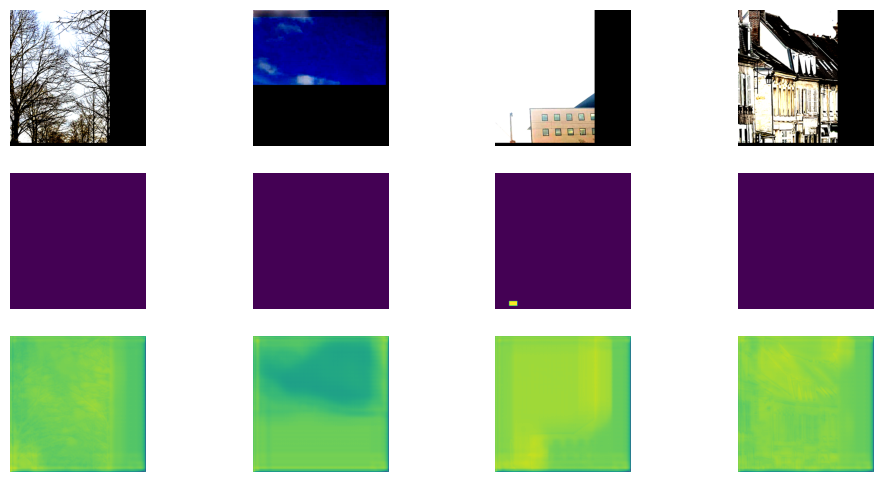

In [17]:

inputs = inputs_cpu.to(device)
labels = labels_cpu.to(device)

fig, axs = plt.subplots(3, 4, figsize=(12, 6))

with torch.set_grad_enabled(False):
    pred = model(inputs)
pred_cpu = pred.cpu().reshape(-1, 512, 512)

print(inputs.shape, pred_cpu.shape)

m = pred_cpu[:].mean()
#pred_cpu[(pred_cpu > m)] = 100
#pred_cpu[(pred_cpu < m)] = 0
 
for idx, ax in enumerate(axs.ravel()):
    if idx // 4 == 0:
        ax.imshow(np.moveaxis(inputs_cpu[idx % 4].numpy(), 0, -1))
    elif idx // 4 == 1:
        ax.imshow(labels_cpu[idx % 4])
    else:
        ax.imshow(pred_cpu[idx % 4])
    ax.axis('off')

torch.Size([8, 3, 512, 512]) torch.Size([8, 512, 512])


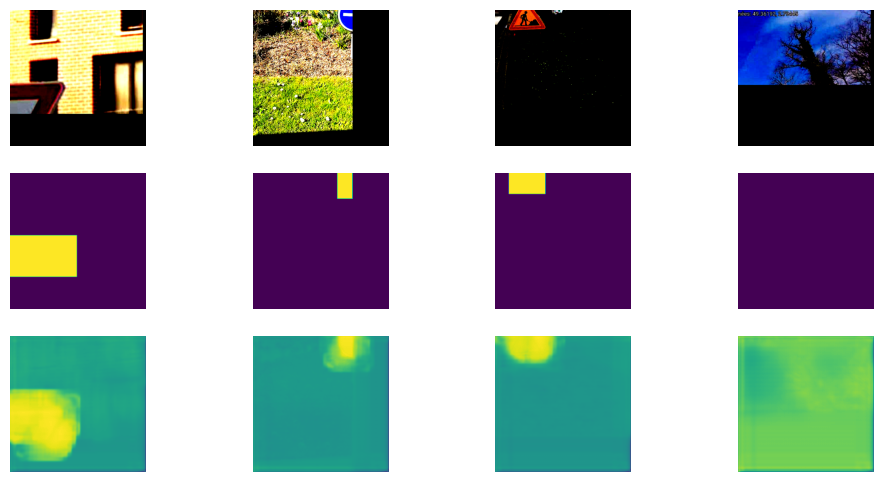

In [26]:
#test_loader1 = DataLoader(dataset, batch_size=8, shuffle=True)
inputs_cpu1, labels_cpu1 = next(iter(test_loader))

inputs = inputs_cpu1.to(device)
labels = labels_cpu1.to(device)

fig, axs = plt.subplots(3, 4, figsize=(12, 6))

with torch.set_grad_enabled(False):
    pred = model(inputs)
pred_cpu = pred.cpu().reshape(-1, 512, 512)

print(inputs.shape, pred_cpu.shape)

for idx, ax in enumerate(axs.ravel()):
    if idx // 4 == 0:
        ax.imshow(np.moveaxis(inputs_cpu1[idx % 4].numpy(), 0, -1))
    elif idx // 4 == 1:
        ax.imshow(labels_cpu1[idx % 4])
    else:
        ax.imshow(pred_cpu[idx % 4])
    ax.axis('off')

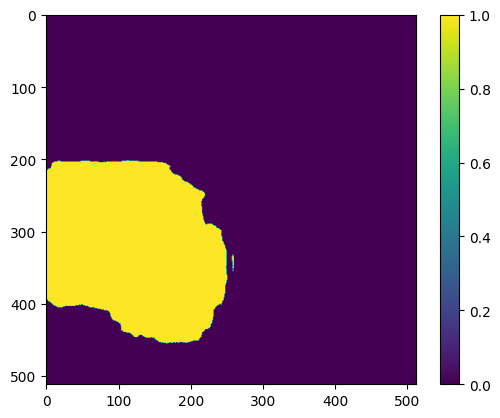

In [31]:
M = pred_cpu[0] > -5
I = plt.imshow(M)
plt.colorbar(I)